In [1]:
# import builtins
# original_print = print
# def custom_print(*args, **kwargs):
#     new_args = []
#     for arg in args:
#         if isinstance(arg, float):
#             new_args.append(f'{arg:.10f}')
#         else:
#             new_args.append(arg)
#     original_print(*new_args, **kwargs)
# builtins.print = custom_print

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
warnings.filterwarnings('ignore')

# Define the variable name for the unit power efficiency column
unit_power_efficiency = 'TH/J'

# Load the data for the maximum efficiency for all dates
max_efficiency_table = pd.read_csv('../../hardwarelist/Bitcoin max updated2.csv')

# Assuming the 'Date' column in max_efficiency_table is in a format that can be converted to datetime
max_efficiency_table['date'] = pd.to_datetime(max_efficiency_table['date'])

data = pd.read_csv('plotdata.csv') # date,row_index,hardware_name,TH/J,max_efficiency,year

# Convert the 'date' column to a datetime format
data['date'] = pd.to_datetime(data['date'])

# keep only data from 2013 onwards
data = data[data['date'] >= '2013-01-01']



ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
# econometrics

# Step 1: Average the data points on a monthly basis
# Ensure that 'TH/J' is a numeric type
data['TH/J'] = pd.to_numeric(data['TH/J'], errors='coerce')

# Create a 'month' column by offsetting the 'date' by 15 days and then using to_period
data['month'] = (data['date'] - timedelta(days=15)).dt.to_period('M')

# Group by 'month' and calculate the mean of 'TH/J'
monthly_data = data.groupby('month')['TH/J'].mean().reset_index()

# Convert 'month' back to datetime (first day of the month)
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# Step 2: Create a time series for power efficiency
# Create the time variable t (in months)
monthly_data['t'] = np.arange(len(monthly_data))+1

# Then, create t^2
monthly_data['t_squared'] = monthly_data['t'] ** 2

# Get the maximum power efficiency over time
def get_max_efficiency(date):
    date = str(date)[:10]
    try:
        return max_efficiency_table[max_efficiency_table['date'] == date]['max (TH/J)'].values[0]
    except:
        return -1
monthly_data['P_max_t'] = monthly_data['month'].apply(lambda x: get_max_efficiency(x))

# Create the log of P_max_t
monthly_data['log_P_max_t'] = np.log(monthly_data['P_max_t'])

# Convert 't' to float to avoid issues with negative powers
monthly_data['t'] = monthly_data['t'].astype(float)

# Define the range of lags to test for the AR and MA components
p_range = range(1, 5)  # AR component
q_range = range(1, 5)  # MA component

best_aic = np.inf
best_bic = np.inf
best_order = None
best_model_fit = None

# Loop over the range of p and q values
for p in p_range:
    for q in q_range:
        try:
            # Fit the ARIMA model with the current p and q values
            model = ARIMA(monthly_data['TH/J'], order=(p, 1, q))
            model_fit = model.fit()
            
            # Check if the current model has a lower AIC or BIC than the best one found so far
            if model_fit.aic < best_aic or model_fit.bic < best_bic:
                best_aic = model_fit.aic
                best_bic = model_fit.bic
                best_order = (p, 1, q)
                best_model_fit = model_fit
        except Exception as e:
            print(f"ARIMA({p},0,{q}) - Model failed to fit: {e}")

# Print the best model's AIC, BIC, and order
print(f"Best ARIMA model order: {best_order}")
print(f"Best ARIMA model AIC: {best_aic}")
print(f"Best ARIMA model BIC: {best_bic}")



Best ARIMA model order: (2, 1, 1)
Best ARIMA model AIC: -1043.9416673702392
Best ARIMA model BIC: -1033.1762758413226


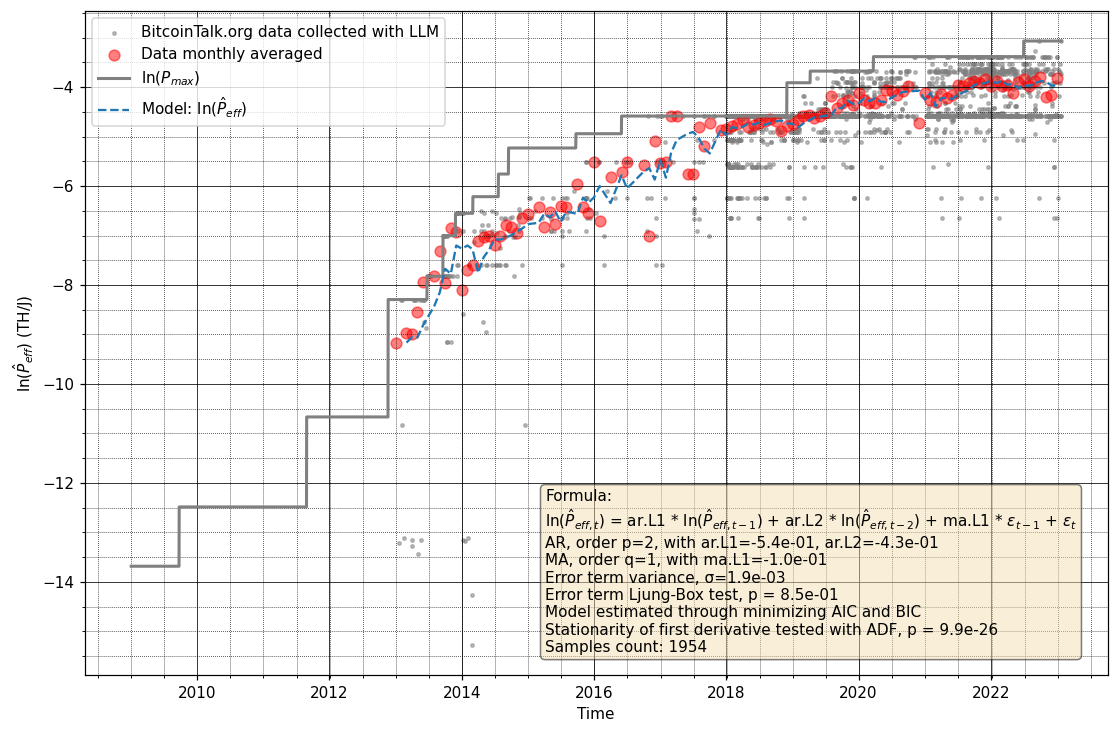

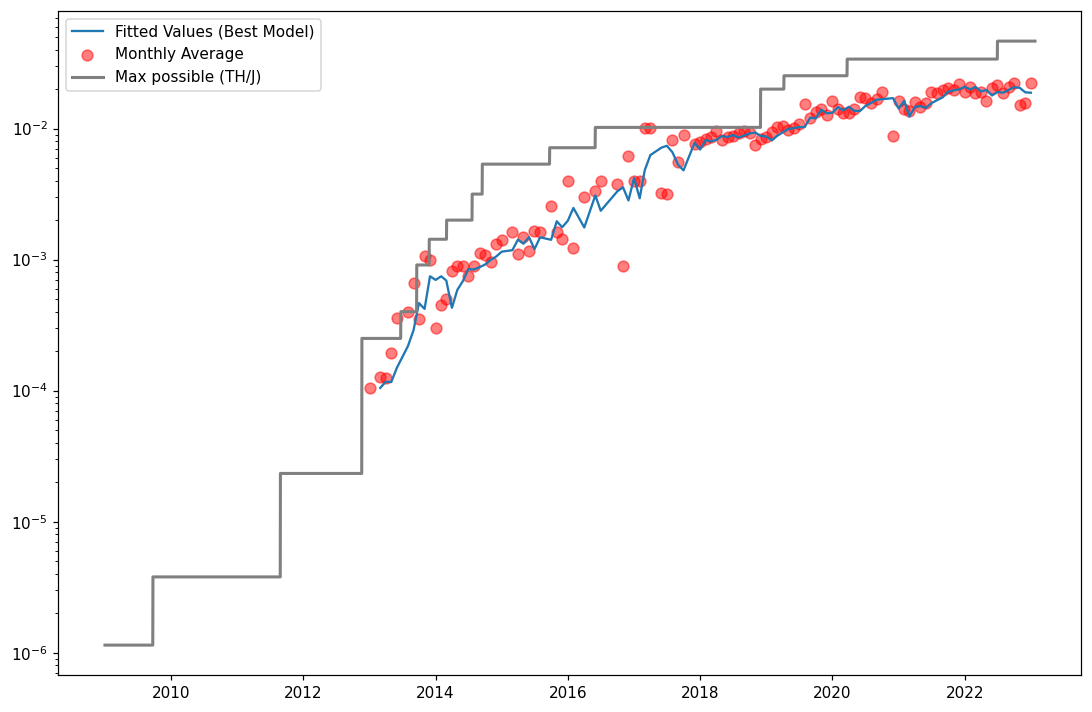

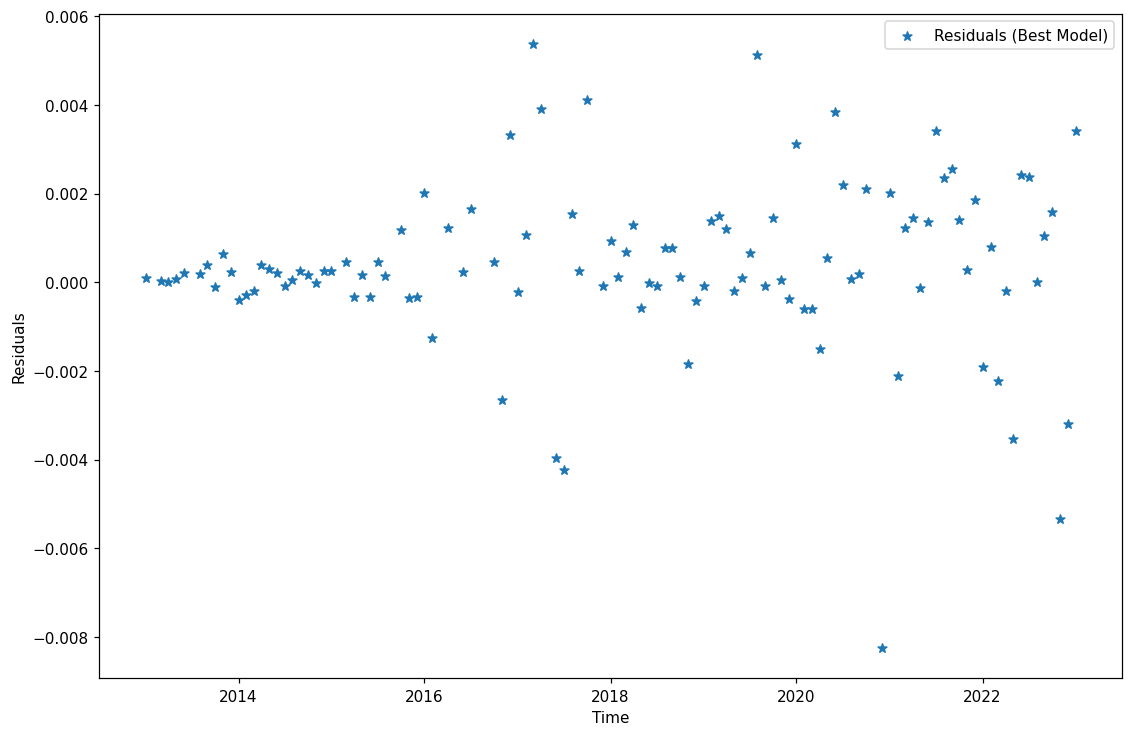

In [ ]:
# Extract the parameter values from the best model fit
params = best_model_fit.params
param_str = ', '.join([f'{key}={value:.3f}' for key, value in params.items()])

dpi = 110

# Step 4: Plot single point for each month + all the data points using the best model
plt.figure(figsize=(12, 8), dpi=dpi)
plt.scatter(data['date'], np.log(data[unit_power_efficiency]), c='gray', s=5, label='BitcoinTalk.org data collected with LLM', alpha=0.5)
plt.scatter(monthly_data['month'], np.log(monthly_data['TH/J']), c='red', s=50, label='Data monthly averaged', alpha=0.5)
plt.plot(max_efficiency_table['date'], np.log(max_efficiency_table['max (TH/J)']), color='gray', label='ln($P_{max}$)', linewidth=2)
plt.plot(monthly_data['month'][1:], np.log(best_model_fit.fittedvalues[1:]), label='Model: ln($\hat{P}_{eff}$)', linestyle='--')
plt.xlabel('Time')
plt.ylabel('ln($\hat{P}_{eff}$) (TH/J)')
plt.yscale('linear')
plt.legend()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.minorticks_on()

# Update the box with model details
ar_params = ', '.join([f'ar.L{i}={params[f"ar.L{i}"]:.1e}' for i in range(1, best_order[0]+1)])
ma_params = ', '.join([f'ma.L{i}={params[f"ma.L{i}"]:.1e}' for i in range(1, best_order[2]+1)])
sigma = params['sigma2']**0.5

textstr = '\n'.join((
    f'Formula:',
    r'ln($\hat{P}_{eff,t}$) = ar.L1 * ln($\hat{P}_{eff,t-1}$) + ar.L2 * ln($\hat{P}_{eff,t-2}$) + ma.L1 * $ε_{t-1}$ + $ε_t$',
    f'AR, order p={best_order[0]}, with {ar_params}',
    f'MA, order q={best_order[2]}, with {ma_params}',
    f'Error term variance, σ={sigma:.1e}',
    f'Error term Ljung-Box test, p = 8.5e-01',
    f'Model estimated through minimizing AIC and BIC',
    f'Stationarity of first derivative tested with ADF, p = 9.9e-26',
    f'Samples count: {len(data)}',
))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# Adjust the position of the box to be next to the plot
plt.gca().text(0.45, 0.28, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.show()

# Step 5: Plot P_eff,t(t) + Single point for each month, excluding the first month from the fitted line using the best model
plt.figure(figsize=(12, 8), dpi=dpi)
# Exclude the first month from the fitted values line
plt.plot(monthly_data['month'][1:], best_model_fit.fittedvalues[1:], label='Fitted Values (Best Model)')
plt.scatter(monthly_data['month'], monthly_data['TH/J'], c='red', s=50, label='Monthly Average', alpha=0.5)
plt.plot(max_efficiency_table['date'], max_efficiency_table['max (TH/J)'], color='gray', label='Max possible (TH/J)', linewidth=2)
plt.yscale('log')
plt.legend()
plt.show()

# Step 6: Plot with just the residual term using the best model, without connecting lines
plt.figure(figsize=(12, 8), dpi=dpi)
plt.scatter(monthly_data['month'], best_model_fit.resid, marker='*', label='Residuals (Best Model)')
plt.yscale('linear')  # Use a linear scale to better visualize the wave pattern
plt.xlabel('Time')  # Label for the x-axis
plt.ylabel('Residuals')  # Label for the y-axis
plt.legend()
plt.show()

In [6]:
# Create a DataFrame with the model's fitted values
model_values_df = pd.DataFrame({
    'month': monthly_data['month'][1:],  # Exclude the first month as it doesn't have a fitted value
    'model_value': best_model_fit.fittedvalues[1:]
})
model_values_df

,month,model_value
1,2013-03-01,0.000105
2,2013-04-01,0.000117
3,2013-05-01,0.000116
4,2013-06-01,0.000149
5,2013-08-01,0.000218
...,...,...
105,2022-09-01,0.019732
106,2022-10-01,0.020699
107,2022-11-01,0.020451
108,2022-12-01,0.018903


In [7]:


# Merge the model_values_df with monthly_data
# Note: Ensure that both DataFrames have the 'date' column in the same format for a successful merge
combined_data = pd.merge(monthly_data, model_values_df, how='left', left_on='month', right_on='month')

# Drop the additional 'date' column from the merge, if needed
# combined_data.drop('month', axis=1, inplace=True)

# Export the combined_data DataFrame to a CSV file
combined_data.to_csv('model_and_monthly_data.csv', index=False) # month,TH/J,t,t_squared,P_max_t,log_P_max_t,model_value

In [8]:
max_eff = pd.read_csv('../hardwarelist/Bitcoin max updated2.csv') # date,max (TH/J),useless,archaicity (TH/J)

# we need a csv with
#Date (day by day from 2009)
#ln(P_max) (TH/J)
#Data monthly average (please put the same value for every day monthly, instead of Na, and then it just changes monthly)
#Model ln(P_eff)

max_eff["month"] = max_eff["date"].apply(lambda x: x[:7]+"-01")
max_eff["month"] = pd.to_datetime(max_eff["month"])
max_eff["ln(P_max)"] = np.log(max_eff["max (TH/J)"])
# max_eff = max_eff[["month","ln(P_max)"]]

combined_data["month"] = pd.to_datetime(combined_data["month"])

data2 = pd.merge(max_eff, combined_data, how='left', left_on='month', right_on='month')
data2 = data2[["date","ln(P_max)","TH/J","model_value"]]
data2 = data2.rename(columns={"date":"Date","ln(P_max)":"ln(P_max)","TH/J":"Data monthly average","model_value":"Model ln(P_eff)"})

# forward fill the missing values
data2 = data2.fillna(method='ffill')

In [9]:
data2.to_csv('model_and_monthly_data_2.csv', index=False)

In [10]:
print(param_str)

ar.L1=-0.543, ar.L2=-0.427, ma.L1=-0.101, sigma2=0.000


In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test on the residuals
lb_test_result = acorr_ljungbox(best_model_fit.resid, lags=[10], return_df=True)

# Display the test results
print(lb_test_result)

     lb_stat  lb_pvalue
10  5.617965   0.846274


In [12]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(monthly_data['TH/J'].dropna())

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] < 0.05:
    print("The time series is stationary with 95% confidence.")
else:
    print("The time series is not stationary with 95% confidence.")

ADF Statistic: -0.567564
p-value: 0.878144
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581
The time series is not stationary with 95% confidence.


In [13]:
from statsmodels.tsa.stattools import adfuller

# Calculate the first derivative of the time series
monthly_data['TH/J_diff'] = monthly_data['TH/J'].diff()

# Drop the first row since it will be NaN after differencing
monthly_data_diff = monthly_data.dropna(subset=['TH/J_diff'])

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(monthly_data_diff['TH/J_diff'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the results
if adf_result[1] < 0.05:
    print("The first derivative of the time series is stationary.")
else:
    print("The first derivative of the time series is not stationary.")

ADF Statistic: -13.766080
p-value: 0.000000
Critical Values:
	1%: -3.493
	5%: -2.889
	10%: -2.581
The first derivative of the time series is stationary.


In [14]:
param_str

'ar.L1=-0.543, ar.L2=-0.427, ma.L1=-0.101, sigma2=0.000'

In [15]:
# # looks like:
# # [
# #  (Timestamp('2011-08-04 00:00:00'), 1.9952745454545455e-06),
# #  (Timestamp('2012-12-31 00:00:00'), 3.2042489473684216e-05),
# #  (Timestamp('2013-12-21 00:00:00'), 0.0005635879322033898)
# # ]
# regression_lines

In [16]:
# df = pd.DataFrame(columns=['date', 'max possible', 'archaicity', 'max found', 'regression'])
# df['date'] = max_efficiency_table['date']
# df['max possible'] = max_efficiency_table['max (TH/J)']
# df['archaicity'] = max_efficiency_table['archaicity (TH/J)']


# # finds the 2 closest timestamps in regression_lines and returns the interpolated value
# def get_regression(date):
#     closest_smaller_timestamp_index = None
#     closest_larger_timestamp_index = None
#     for (i,(timestamp, value)) in enumerate(regression_lines):
#         if timestamp <= date:
#             closest_smaller_timestamp_index = i
#         else:
#             closest_larger_timestamp_index = i
#             break
    
#     if closest_smaller_timestamp_index is None:
#         return regression_lines[0][1]
#     elif closest_larger_timestamp_index is None:
#         return regression_lines[-1][1]
    
#     smaller_value = regression_lines[closest_smaller_timestamp_index][1]
#     larger_value = regression_lines[closest_larger_timestamp_index][1]

#     # interpolate
#     return smaller_value + (larger_value - smaller_value) * (date - regression_lines[closest_smaller_timestamp_index][0]) / (regression_lines[closest_larger_timestamp_index][0] - regression_lines[closest_smaller_timestamp_index][0])

     
# df['regression'] = df['date'].apply(get_regression)

# # gets the max efficiency for a given date from the data table
# def get_max_efficiency(date):
#     return data[data['date'] == date][unit_power_efficiency].max()

# df['max found'] = df['date'].apply(get_max_efficiency)

In [17]:
# df.sample(30)

In [18]:
# df.to_csv('plot.csv', index=False)